In [34]:
import os

import tensorflow.compat.v1 as tf
from nn_regressors import CNN, RNN, benchmark_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import numpy as np

from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D

from lstm import create_lstm
from seq2seq import create_seq2seq

In [11]:
def clear_saved_regressors():
    to_delete = [
        "cnn_cpu.joblib",
        "cnn_mem.joblib",
        "rnn_cpu.joblib",
        "rnn_mem.joblib",
    ]
    for file in to_delete:
        if os.path.exists(file):
            os.remove(file)

In [12]:
clear_saved_regressors()

In [13]:
rnn_cpu_reg = RNN.CPURegressor()
rnn_mem_reg = RNN.MemoryRegressor()

In [14]:
# Instantiate example models.
lstm = create_lstm()
enc, dec = create_seq2seq()


models = [lstm, enc, dec]
for model in models:
    rnn_cpu_reg.add_model_data(model)
    rnn_mem_reg.add_model_data(model)


In [15]:
# Compare different regressor types

# Defines custom loss function for LGBM that penalizes underestimates.
# See https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual > 0, -2 * 10.0 * residual, -2 * residual)
    hess = np.where(residual > 0, 2 * 10.0, 2.0)
    return grad, hess


gbm = lgb.LGBMRegressor()
gbm.set_params(
    **{"objective": custom_asymmetric_train, "num_leaves": 70, "max_bin": 400}, metrics=["mse", "mae"]
)


def get_regressors():
    return [
        Ridge(),
        RandomForestRegressor(n_estimators=750, random_state=42, criterion="mae"),
        Lasso(),
        ElasticNet(),
        SVR(),
        NuSVR(),
        gbm,
    ]

In [16]:
import matplotlib.pyplot as plt
def bar_plot(data_df, title, xlabel, ylabel):
    plt.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    plt.show()

#     def bar_plot(ax, data_df, title, xlabel, ylabel):
#     ax.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
#     ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     ax.set_xlabel(xlabel)
# #     ax.set_xticks(rotation=90)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)

# MASE evaluations

In [18]:
# Fit regressors to new model data.
rnn_cpu_reg.fit(model=SVR())  # Fit an SvR model
rnn_mem_reg.fit()  # default to Random Forest

(   units  filters  kernel_size  activation_tanh  activation_nan  \
 3   10.0     -1.0           -1                1               0   
 4   32.0     -1.0           -1                1               0   
 1  256.0     -1.0           -1                1               0   
 
    activation_selu  activation_elu  activation_softmax  activation_softplus  \
 3             -1.0            -1.0                -1.0                 -1.0   
 4             -1.0            -1.0                -1.0                 -1.0   
 1             -1.0            -1.0                -1.0                 -1.0   
 
    activation_softsign  activation_relu  activation_sigmoid  \
 3                 -1.0             -1.0                -1.0   
 4                 -1.0             -1.0                -1.0   
 1                 -1.0             -1.0                -1.0   
 
    activation_hard_sigmoid  activation_exponential  activation_linear  \
 3                     -1.0                    -1.0               -1.0  

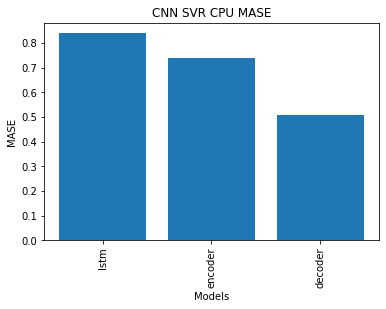

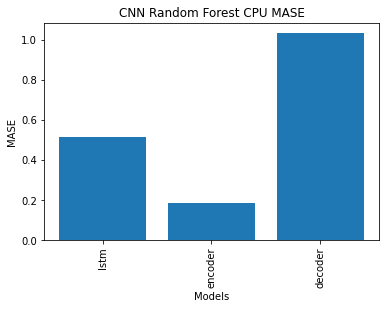

In [19]:
# Predicting CPU for models the regressor was trained on

rnn_cpu_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(models), "CNN SVR CPU MASE", "Models", "MASE")

rnn_cpu_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(models), "CNN Random Forest CPU MASE", "Models", "MASE")

Saving model...
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph=conv_lstm.pbtxt --input_layer="embedding_input:0" --input_layer_shape="1,100" --output_layer="activation/Sigmoid:0"
Running benchmark...
Done.
Saving model...
INFO:tensorflow:Froze 9 variables.
INFO:tensorflow:Converted 9 variables to const ops.
../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph=bidirectional_lstm.pbtxt --input_layer="embedding_input:0" --input_layer_shape="1,100" --output_layer="dense/Sigmoid:0"
Running benchmark...
Done.


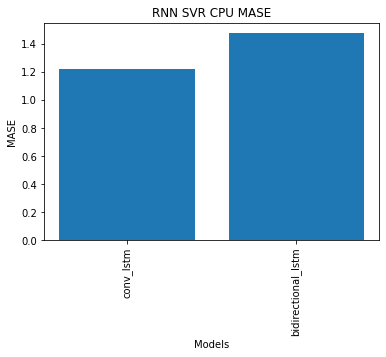

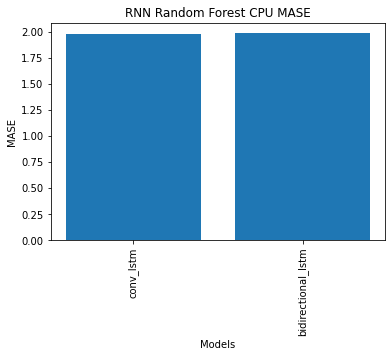

In [39]:
# Predicting CPU for models the regressor was NOT trained on
tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
test_rnn = Sequential(name="conv_lstm")
test_rnn.add(Embedding(20000, 128, input_length=100))
test_rnn.add(Dropout(0.25))
test_rnn.add(Conv1D(64,
                 5,
                 padding='valid',
                 activation='relu',
                 strides=1))
test_rnn.add(MaxPooling1D(pool_size=4))
test_rnn.add(LSTM(70))
test_rnn.add(Dense(1))
test_rnn.add(Activation('sigmoid'))
test_rnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


mase_1 = rnn_cpu_reg.evaluate_mase(test_rnn)


tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
test_rnn_2 = Sequential(name="bidirectional_lstm")
test_rnn_2.add(Embedding(20000, 128, input_length=100))
test_rnn_2.add(Bidirectional(LSTM(64)))
test_rnn_2.add(Dropout(0.5))
test_rnn_2.add(Dense(1, activation='sigmoid'))
test_rnn_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

mase_2 = rnn_cpu_reg.evaluate_mase(test_rnn_2)

new_models = [test_rnn, test_rnn_2]
rnn_cpu_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(new_models), "RNN SVR CPU MASE", "Models", "MASE")

rnn_cpu_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_cpu_reg.evaluate_mase_multiple(new_models), "RNN Random Forest CPU MASE", "Models", "MASE")

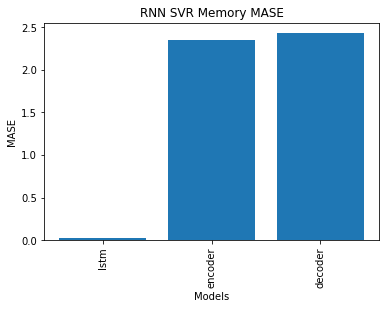

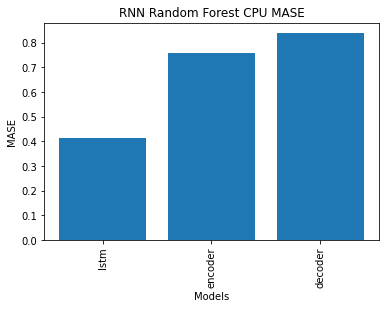

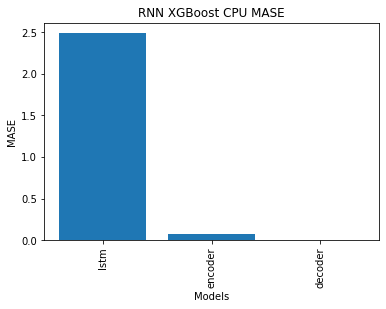

In [36]:
# Predicting memory for models the regressor was trained on

rnn_mem_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(models), "RNN SVR Memory MASE", "Models", "MASE")

rnn_mem_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(models), "RNN Random Forest CPU MASE", "Models", "MASE")

rnn_mem_reg.fit(model=gbm)  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(models), "RNN XGBoost CPU MASE", "Models", "MASE")

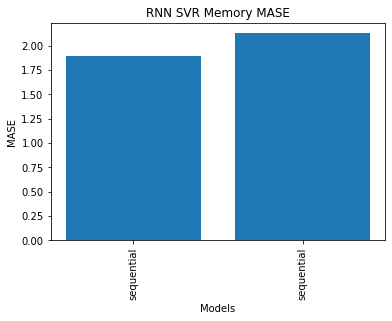

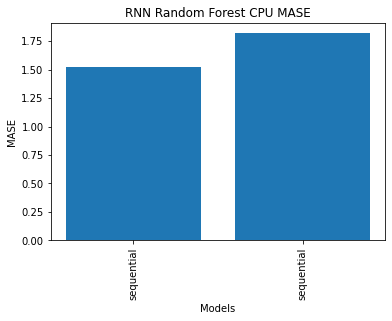

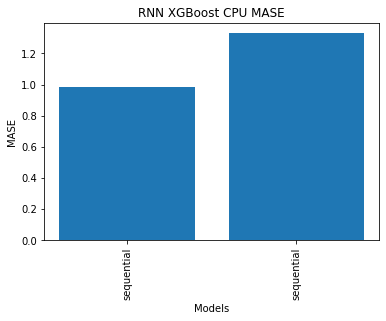

In [37]:
# Predicting memory for models the regressor was NOT trained on

rnn_mem_reg.fit(model=SVR())  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(new_models), "RNN SVR Memory MASE", "Models", "MASE")

rnn_mem_reg.fit(model=RandomForestRegressor(n_estimators=1000, random_state=42))  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(new_models), "RNN Random Forest CPU MASE", "Models", "MASE")

rnn_mem_reg.fit(model=gbm)  # Fit an SVR model
bar_plot(rnn_mem_reg.evaluate_mase_multiple(new_models), "RNN XGBoost CPU MASE", "Models", "MASE")

# Comparisons of different regression models

In [8]:
mobilenet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), mobilenet)
resnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), resnet)
densenet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), densenet)
xception_cpu_eval = cnn_cpu_reg.compare(get_regressors(), xception)

mobilenet_mem_eval = cnn_mem_reg.compare(get_regressors(), mobilenet)
resnet_mem_eval = cnn_mem_reg.compare(get_regressors(), resnet)
densenet_mem_eval = cnn_mem_reg.compare(get_regressors(), densenet)
xception_mem_eval = cnn_mem_reg.compare(get_regressors(), xception)

In [13]:
inception_resnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), inception_resnet)
nasnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), nasnet)
vgg16_cpu_eval = cnn_cpu_reg.compare(get_regressors(), vgg16)
inception_cpu_eval = cnn_cpu_reg.compare(get_regressors(), inception)

inception_resnet_mem_eval = cnn_mem_reg.compare(get_regressors(), inception_resnet)
nasnet_mem_eval = cnn_mem_reg.compare(get_regressors(), nasnet)
vgg16_mem_eval = cnn_mem_reg.compare(get_regressors(), vgg16)
inception_mem_eval = cnn_mem_reg.compare(get_regressors(), inception)

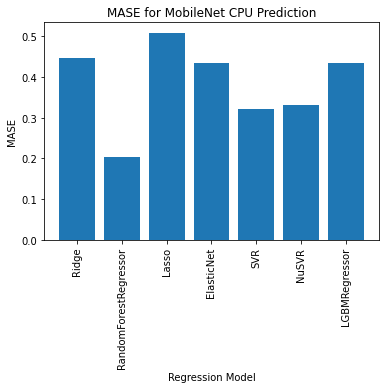

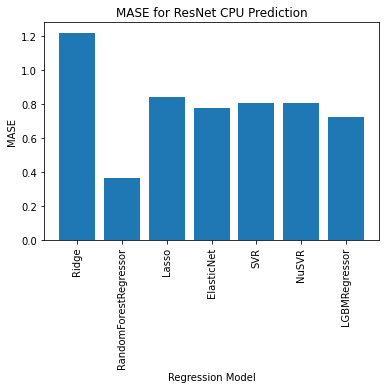

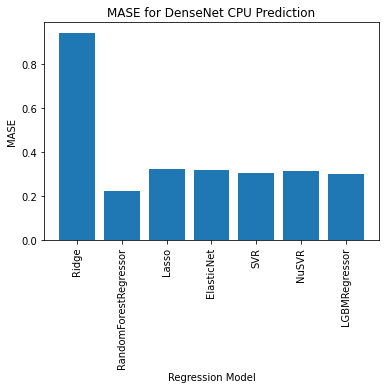

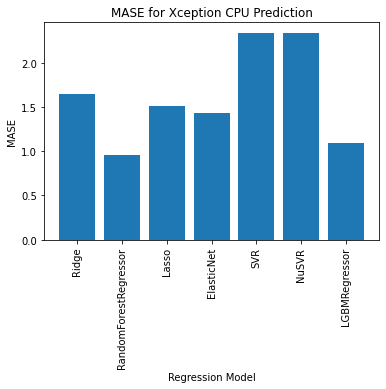

In [14]:
# CPU Predictions for models already trained on
bar_plot(mobilenet_cpu_eval, 'MASE for MobileNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(resnet_cpu_eval, 'MASE for ResNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(densenet_cpu_eval, 'MASE for DenseNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(xception_cpu_eval, 'MASE for Xception CPU Prediction', 'Regression Model', 'MASE')

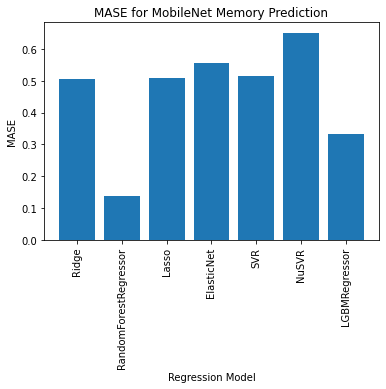

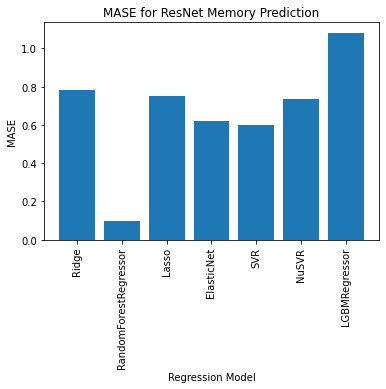

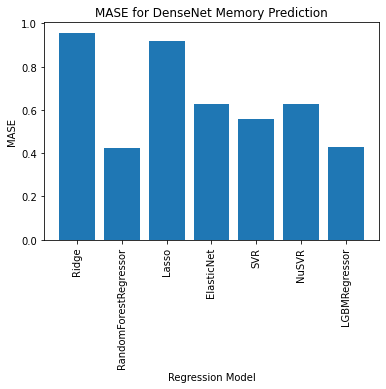

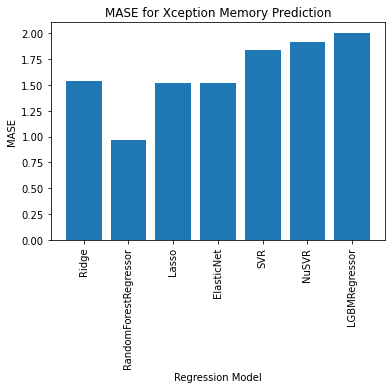

In [15]:
# Memory Predictions for models already trained on
bar_plot(mobilenet_mem_eval, 'MASE for MobileNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(resnet_mem_eval, 'MASE for ResNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(densenet_mem_eval, 'MASE for DenseNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(xception_mem_eval, 'MASE for Xception Memory Prediction', 'Regression Model', 'MASE')

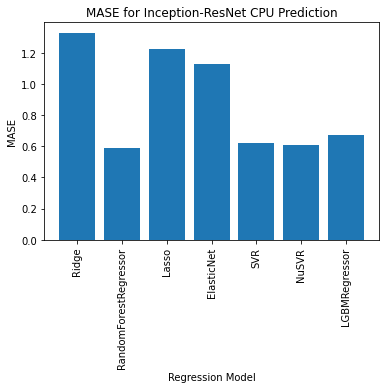

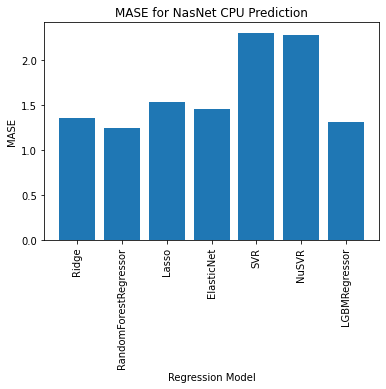

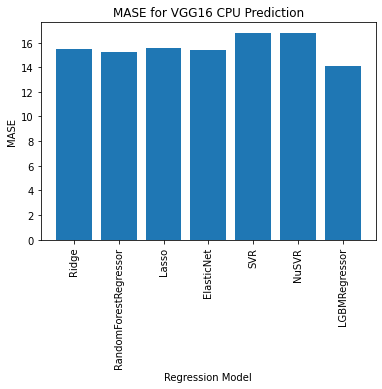

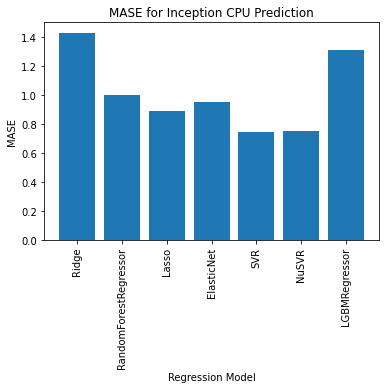

In [16]:
# CPU Predictions for models NOT trained on
bar_plot(inception_resnet_cpu_eval, 'MASE for Inception-ResNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(nasnet_cpu_eval, 'MASE for NasNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(vgg16_cpu_eval, 'MASE for VGG16 CPU Prediction', 'Regression Model', 'MASE')
bar_plot(inception_cpu_eval, 'MASE for Inception CPU Prediction', 'Regression Model', 'MASE')

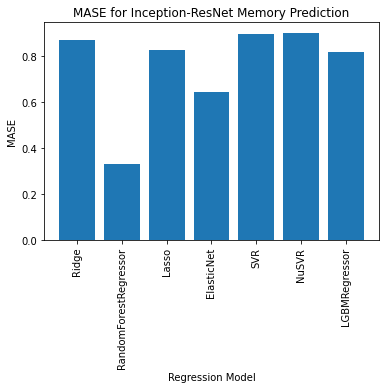

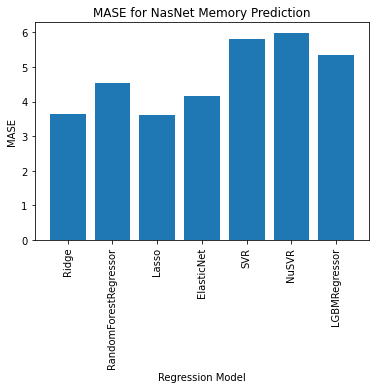

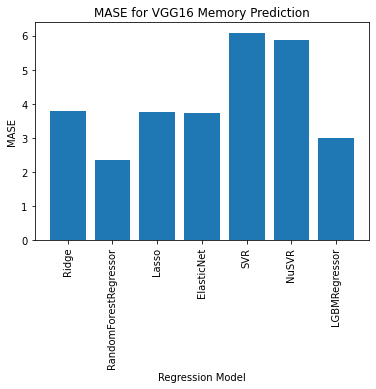

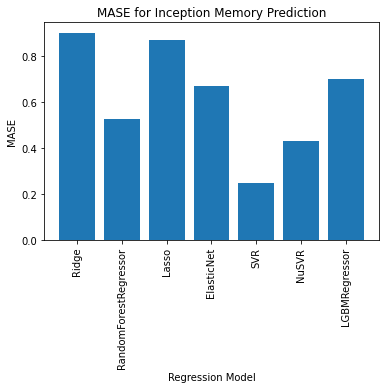

In [17]:
# Memory Predictions for models NOT trained on
bar_plot(inception_resnet_mem_eval, 'MASE for Inception-ResNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(nasnet_mem_eval, 'MASE for NasNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(vgg16_mem_eval, 'MASE for VGG16 Memory Prediction', 'Regression Model', 'MASE')
bar_plot(inception_mem_eval, 'MASE for Inception Memory Prediction', 'Regression Model', 'MASE')